In [194]:
import os
import wfdb as wf
import numpy as np
import matplotlib.pyplot as plt
from biosppy.signals import ecg
import glob
from scipy import signal
import pandas as pd
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix



In [195]:
filepaths_glob=glob.iglob('/Users/aring/jupyter/differential-privacy/data/Arno/ECGDataDenoised/*.csv')
filepaths=[]
count=0
for filepath in filepaths_glob:
    filepaths.append(filepath)

In [196]:
# Loop through each input file. Each file contains one
# record of ECG readings, sampled at 500 readings per
# second. Find the peaks and downsamples each beat and make it 186 points

TARGET_SAMPLING_RATE=125
DATA_SAMPLING_RATE=500
INPUT_BEAT_SIZE=187
patient_id=0
savedata = np.empty((0,INPUT_BEAT_SIZE+1), dtype=np.float)

for path in filepaths:
#     print('patient_id: '+str(patient_id))
    record=pd.read_csv(path,header=None)
    channel = record[1].values
    
    try:
        out = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
    except Exception as e: # work on python 3.x
        print('Failed to upload to ftp: '+ str(e))
        continue
    
    beatstoremove = np.array([0])
    beats = np.split(channel, out['rpeaks'])
    for idx, idxval in enumerate(out['rpeaks']):
        firstround = idx == 0
        lastround = idx == len(beats) - 1
        # Skip first and last beat.
        if (firstround or lastround):
            continue

        # Normalize the readings to a 0-1 range for ML purposes.
        beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

        # Resample from 500HZ to 125Hz
        newsize = int((beats[idx].size * TARGET_SAMPLING_RATE / DATA_SAMPLING_RATE) + 0.5)
        beats[idx] = signal.resample(beats[idx], newsize)

        #Skipping records that are too long.
        if (beats[idx].size > INPUT_BEAT_SIZE):
            beatstoremove = np.append(beatstoremove, idx)
            continue

        #Pad with zeroes.
        zerocount = INPUT_BEAT_SIZE - beats[idx].size
        beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

        # Append the person ID to the beat data.
        beats[idx] = np.append(beats[idx], float(patient_id))
            
    beatstoremove = np.append(beatstoremove, len(beats)-1)
    beats = np.delete(beats, beatstoremove)
    if ( np.array(list(beats[:])).ndim==2 ):
        savedata = np.append(savedata, np.array(list(beats[:]), dtype=np.float), axis=0)
    else:
        print('no data for this patinet: '+ str(patient_id))
        continue
    
    patient_id=patient_id+1


# Save to CSV file.
outfn = '/Users/aring/jupyter/differential-privacy/data/Arno/ECG-identification-input/lead1.csv'
print('Generating ', outfn)
with open(outfn, "wb") as fin:
    np.savetxt(fin, savedata, delimiter=",", fmt='%f')

no data for this patinet: 689
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart rate.
Failed to upload to ftp: Not enough beats to compute heart r

In [197]:
alldata_v1=np.loadtxt('/Users/aring/jupyter/differential-privacy/data/Arno/ECG-identification-input/lead1.csv', delimiter=',')

In [198]:
totrows=alldata_v1.shape[0]
totrows

128170

In [199]:

# Randomly mix rows
np.random.seed(897)
np.random.shuffle(alldata_v1)


trainrows_count = int((totrows * 7/ 10) + 0.5) # 70% for training
print('total rows'+str(totrows))
print('training rows'+str(trainrows_count))


with open('/Users/aring/jupyter/differential-privacy/data/Arno/ECG-identification-input//train.csv', "wb") as fin:
    np.savetxt(fin, alldata_v1[:trainrows_count], delimiter=",", fmt='%f')
with open('/Users/aring/jupyter/differential-privacy/data/Arno/ECG-identification-input/test.csv', "wb") as fin:
    np.savetxt(fin, alldata_v1[trainrows_count:], delimiter=",", fmt='%f')

total rows128170
training rows89719


In [200]:
# Training dataset.

train_df = pd.read_csv("/Users/aring/jupyter/differential-privacy/data/Arno/ECG-identification-input/train.csv", header=None)
X_train=train_df.iloc[:,:186].values
train_df[187]=train_df[187].astype(int)
target_train=train_df[187]
y_train=to_categorical(target_train)
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)

#test dataset
test_df = pd.read_csv("/Users/aring/jupyter/differential-privacy/data/Arno/ECG-identification-input/test.csv", header=None)
X_test=test_df.iloc[:,:186].values
test_df[187]=test_df[187].astype(int)
target_test=test_df[187]
y_test=to_categorical(target_test)
X_test= X_test.reshape(len(X_test), X_test.shape[1],1)


In [201]:
y_train.shape

(89719, 10600)

In [202]:
test_df[187].value_counts()

6516     15
7827     14
6633     14
8060     14
10093    14
         ..
5508      1
3463      1
1446      1
7621      1
4023      1
Name: 187, Length: 10226, dtype: int64

In [203]:
num_of_people_in_data =len(set(test_df[187]).union(set(train_df[187])))
num_of_people_in_data

10600

In [204]:
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(50, activation='relu')(dense_end1)
    main_output = Dense(num_of_people_in_data, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [205]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [206]:
model,history=network(X_train,y_train,X_test,y_test)

Train on 89719 samples, validate on 38451 samples
Epoch 1/40
89719/89719 [==============================] - 113s 1ms/step - loss: 7.7842 - acc: 0.0169 - val_loss: 6.5043 - val_acc: 0.0442
Epoch 2/40
89719/89719 [==============================] - 110s 1ms/step - loss: 5.2252 - acc: 0.1225 - val_loss: 5.0908 - val_acc: 0.1633
Epoch 3/40
89719/89719 [==============================] - 119s 1ms/step - loss: 3.9435 - acc: 0.2518 - val_loss: 4.3574 - val_acc: 0.2526
Epoch 4/40
89719/89719 [==============================] - 117s 1ms/step - loss: 3.1751 - acc: 0.3549 - val_loss: 3.7327 - val_acc: 0.3543
Epoch 5/40
89719/89719 [==============================] - 502s 6ms/step - loss: 2.6881 - acc: 0.4268 - val_loss: 3.4657 - val_acc: 0.3913
Epoch 6/40
89719/89719 [==============================] - 124s 1ms/step - loss: 2.3332 - acc: 0.4853 - val_loss: 3.1861 - val_acc: 0.4398
Epoch 7/40
89719/89719 [==============================] - 113s 1ms/step - loss: 2.0662 - acc: 0.5329 - val_loss: 2.9734 - 

Accuracy: 69.27%


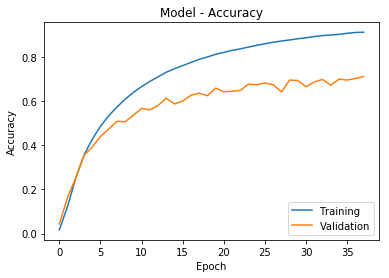

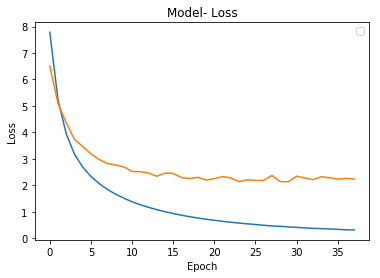

In [207]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [208]:
#predicted class vs actual, some examples
print(list(y_pred.argmax(axis=1)[1:20]))
print(list(target_test[1:20]))

[1190, 9440, 1921, 1423, 9576, 618, 7497, 6446, 2743, 5174, 9560, 1921, 2872, 7265, 3929, 10561, 6658, 8692, 2648]
[1190, 3742, 6107, 1423, 9576, 618, 9506, 6446, 2743, 5174, 9560, 1921, 2872, 4611, 3929, 10561, 6658, 8692, 8042]
